In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

%matplotlib inline

img = mpimg.imread('test_images/test5.jpg')

In [30]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]

thresh = (150, 255)
hls_bin = np.zeros_like(S)
hls_bin[(S > thresh[0]) & (S <= thresh[1])] = 1

R = img[:,:,0]
rgb_bin = np.zeros_like(R)
rgb_bin[(R > thresh[0]) & (R <= thresh[1])] = 1

rs_bin = np.zeros_like(R)
rs_bin[(R > thresh[0]) & (R <= thresh[1]) & (S > thresh[0]) & (S <= thresh[1])] = 1

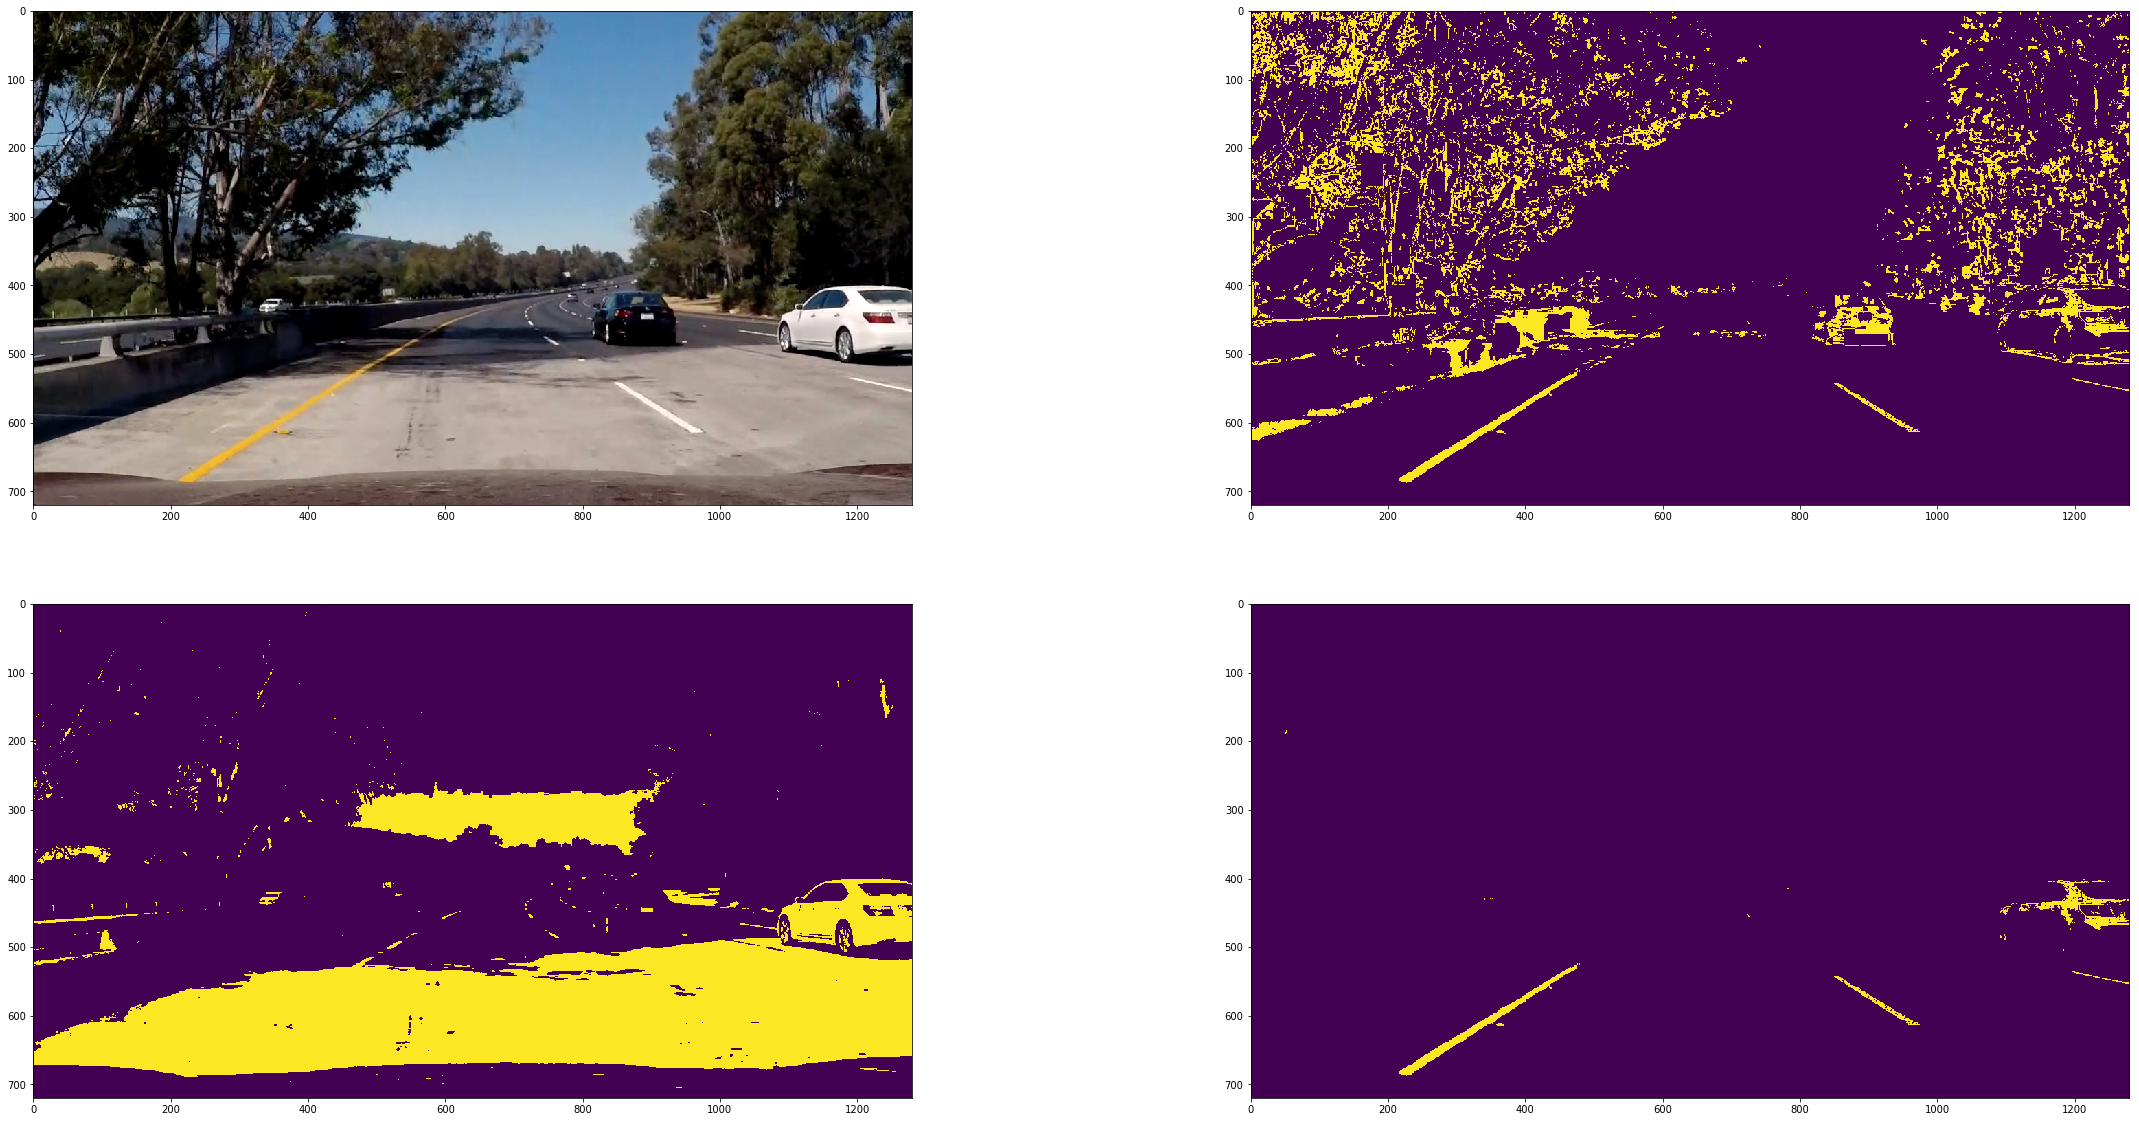

In [31]:
f, ax = plt.subplots(2,2, figsize=(40, 20))
ax[0,0].imshow(img)
ax[0,1].imshow(hls_bin)
ax[1,0].imshow(rgb_bin)
ax[1,1].imshow(rs_bin)

### The Path demarkated

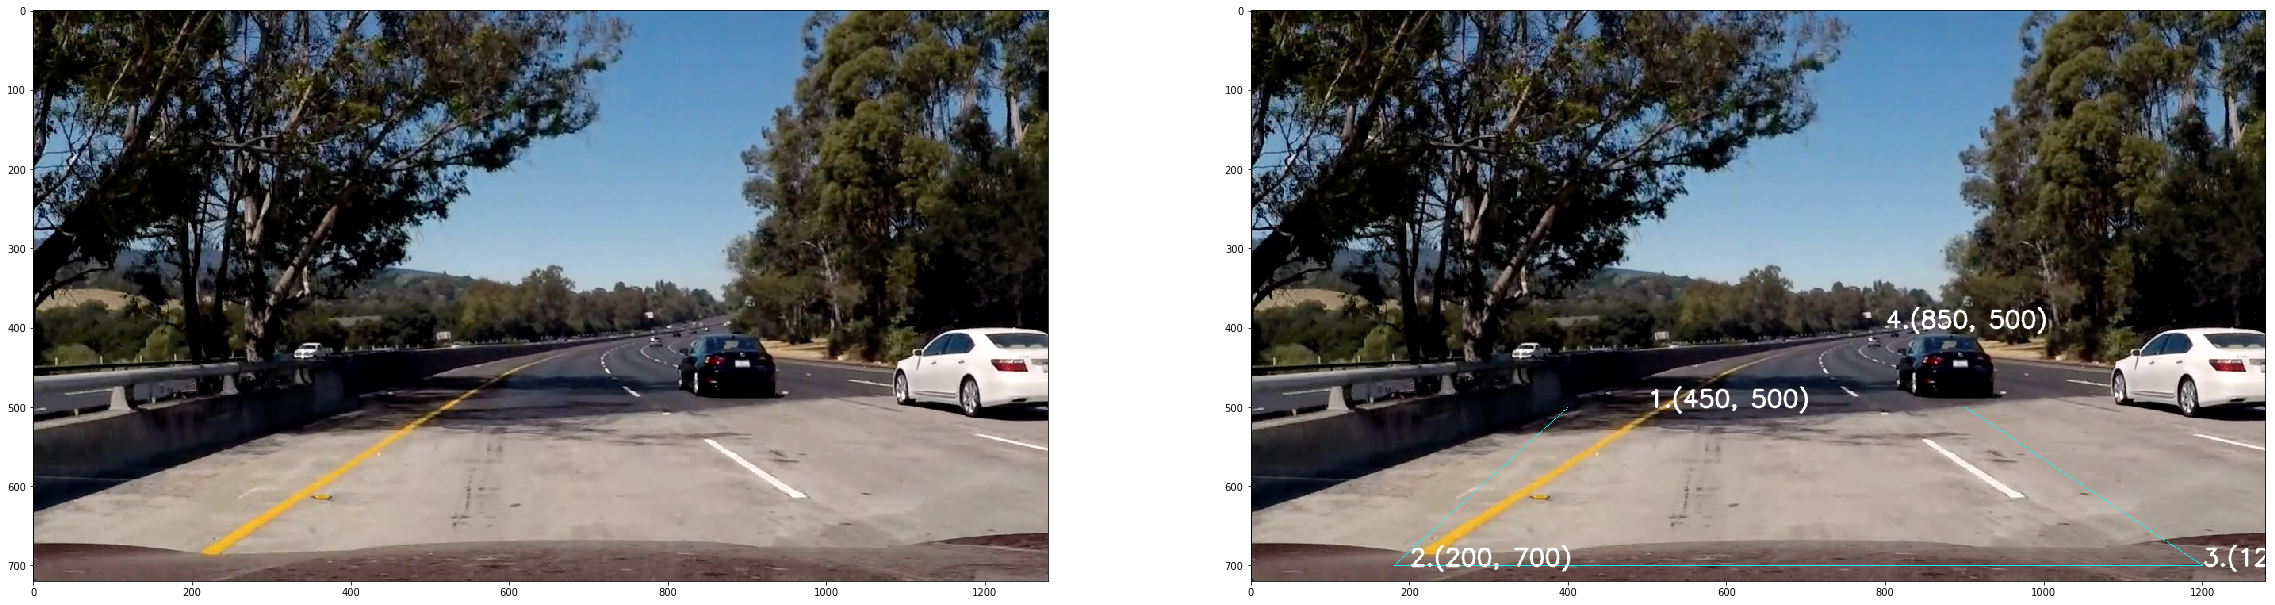

In [35]:
img_copy = np.copy(img)

#                (x1, y1), (x2, y2), (x3, y3), (x4, y4)
# http://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
pts = np.array([[400, 500],[180, 700],[1200, 700],[900, 500]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(img_copy,[pts],True,(0,255,255))

font = cv2.FONT_HERSHEY_SIMPLEX
font_color = (255,255,255)
cv2.putText(img_copy,'1.(450, 500)',(500, 500), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'2.(200, 700)',(200, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'3.(1200, 700)',(1200, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy,'4.(850, 500)',(800, 400), font, 1,font_color,2,cv2.LINE_AA)

f, ax = plt.subplots(1,2, figsize=(40, 20))
ax[0].imshow(img)
ax[1].imshow(img_copy)

### Warp the image

In [36]:
def warp(img, src, dst):
    image_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, image_size, flags= cv2.INTER_LINEAR)

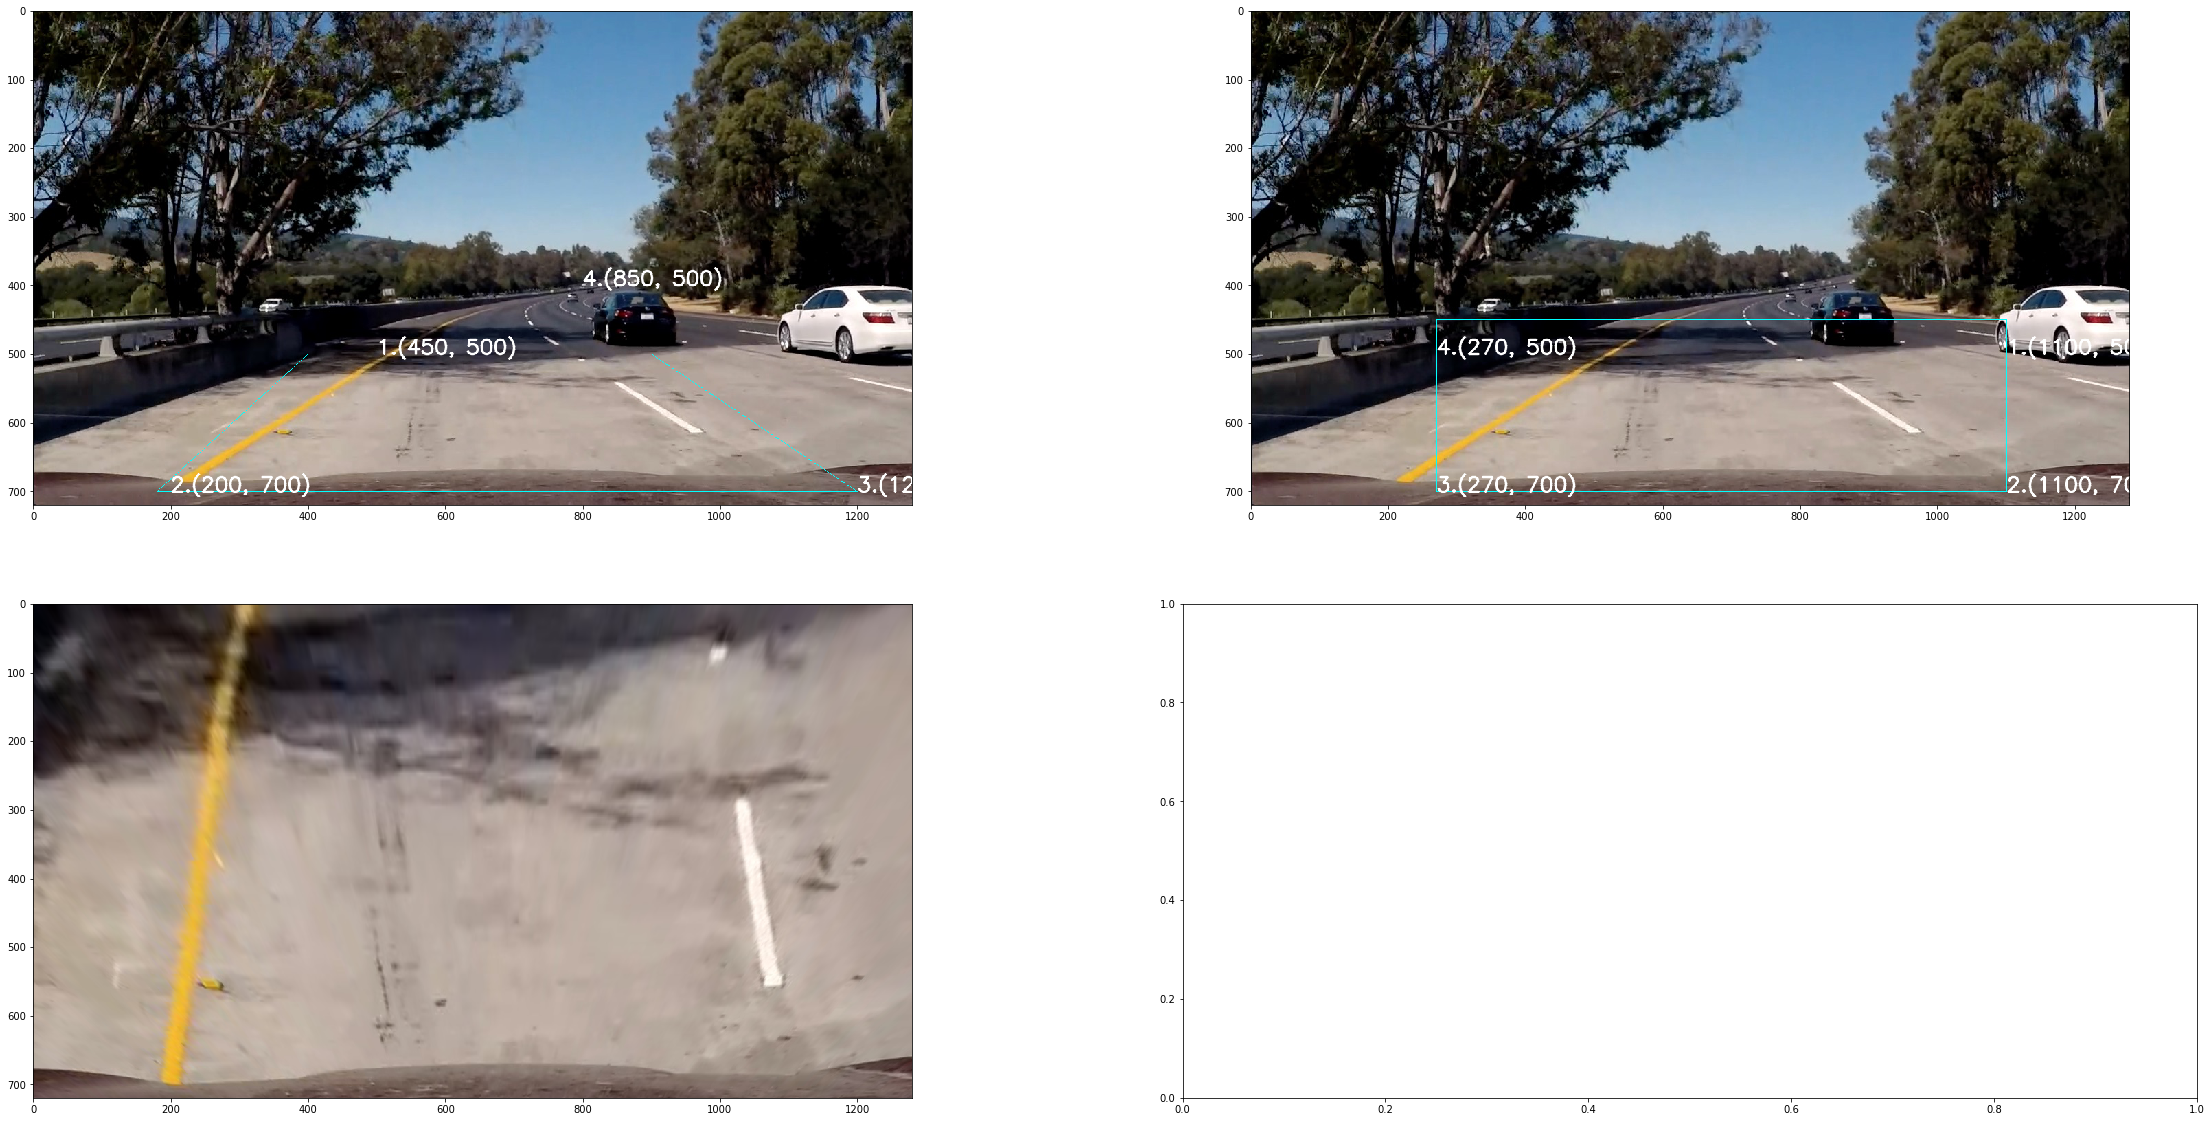

In [41]:
src = np.float32([[900, 500], [1280, 700], [0, 700], [400, 500]])
dst = np.float32([[img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]], [0, 0]])

warped_img = warp(img, src, dst)

img_copy2 = np.copy(img)

#                (x1, y1), (x2, y2), (x3, y3), (x4, y4)
# http://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
pts = np.array([(1100, 450), (1100, 700), (270, 700), (270, 450)], np.int32)
pts = pts.reshape((-1,1,2))

cv2.polylines(img_copy2,[pts],True,(0,255,255))
cv2.putText(img_copy2,'1.(1100, 500)',(1100, 500), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'2.(1100, 700)',(1100, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'3.(270, 700)',(270, 700), font, 1,font_color,2,cv2.LINE_AA)
cv2.putText(img_copy2,'4.(270, 500)',(270, 500), font, 1,font_color,2,cv2.LINE_AA)

f, ax = plt.subplots(2,2, figsize=(40, 20))
ax[0,0].imshow(img_copy)
ax[0,1].imshow(img_copy2)
ax[1,0].imshow(warped_img)

# Warped road line in gray

In [42]:
warped_rgb_bin = warp(hls_bin, src, dst)

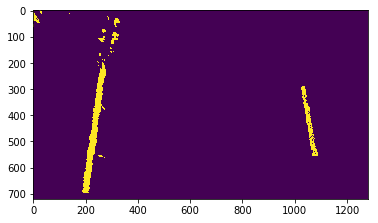

In [43]:
plt.imshow(warped_rgb_bin)

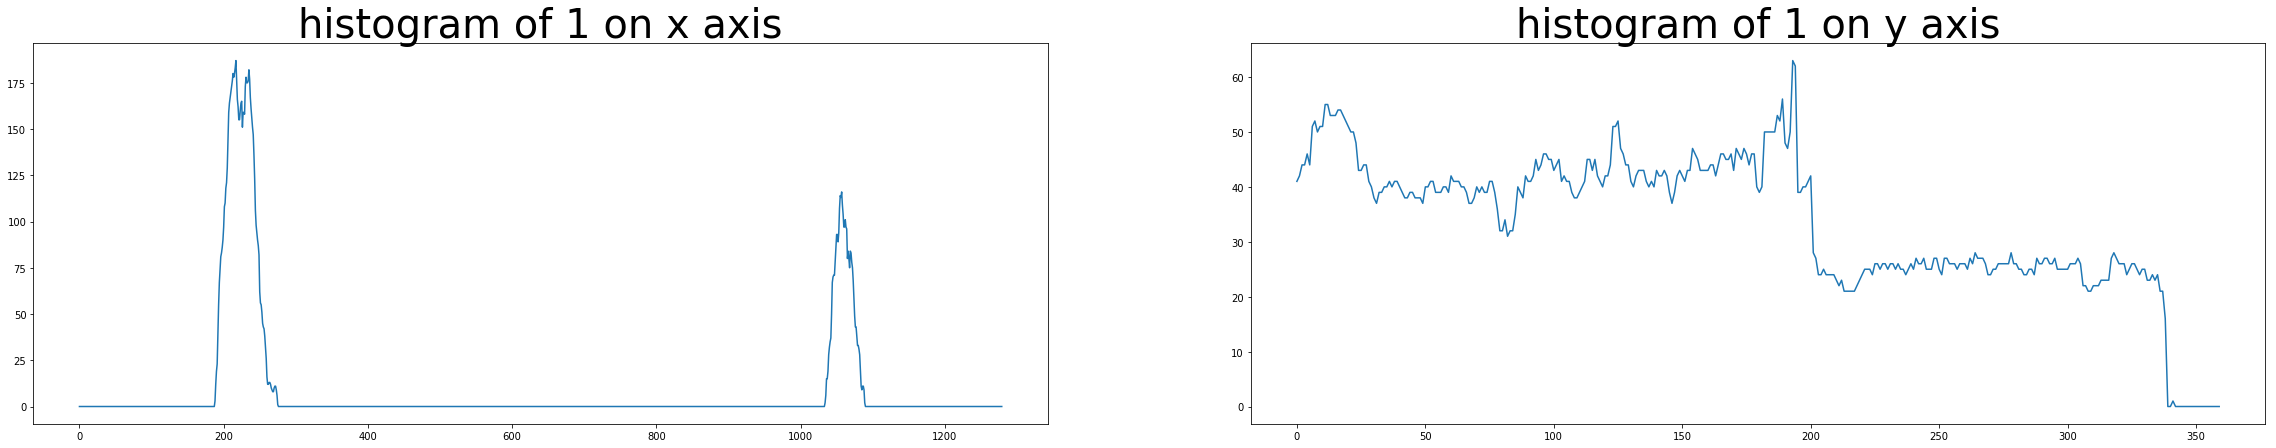

In [44]:
histogramx = np.sum(warped_rgb_bin[warped_rgb_bin.shape[0]//2:, :], axis=0)
histogramy = np.sum(warped_rgb_bin[warped_rgb_bin.shape[0]//2:, :], axis=1)

f, ax = plt.subplots(1,2, figsize=(40, 7))
ax[0].plot(histogramx)
ax[0].set_title("histogram of 1 on x axis", fontsize=40)
ax[1].plot(histogramy)
ax[1].set_title("histogram of 1 on y axis", fontsize=40)

### create a binary image to draw on

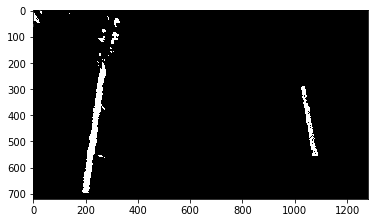

In [45]:
out_img = np.dstack((warped_rgb_bin, warped_rgb_bin, warped_rgb_bin)) * 255
plt.imshow(out_img)

In [46]:
print(histogramx)
midpoint = np.int(len(histogramx)/2)
leftx_base = np.argmax(histogramx[:midpoint])
rightx_base = np.argmax(histogramx[midpoint:]) + midpoint

print("midpoint: ", midpoint, "leftx_base: ", leftx_base, "rightx_base: ", rightx_base)

[0 0 0 ..., 0 0 0]
midpoint:  640 leftx_base:  217 rightx_base:  1057


In [47]:
nwindows = 9
window_height = np.int(warped_rgb_bin.shape[0]/nwindows)

(array([  0,   0,   0, ..., 698, 698, 701]), array([  0,   1,  22, ..., 212, 213, 208]))


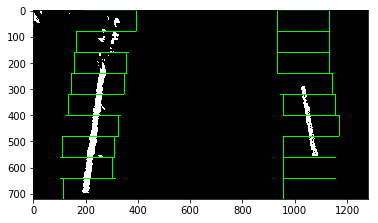

In [48]:
nonzero = warped_rgb_bin.nonzero()
print(nonzero)
nonzerox = nonzero[1]
nonzeroy = nonzero[0]

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 70

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = warped_rgb_bin.shape[0] - (window+1)*window_height
    win_y_high = warped_rgb_bin.shape[0] - (window)*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
plt.imshow(out_img)

In [49]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

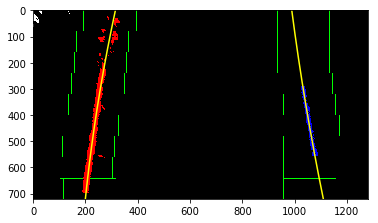

In [50]:
ploty = np.linspace(0, warped_rgb_bin.shape[0]-1, warped_rgb_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [51]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [52]:
src = np.float32([[750, 450], [1100, 700], [270, 700], [600, 450]])
dst = np.float32([[img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]], [0, 0]])

def pipeline(img, src, dst):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    thresh = (150, 255)
    hls_bin = np.zeros_like(S)
    hls_bin[(S > thresh[0]) & (S <= thresh[1])] = 1

    warped_img = warp(hls_bin, src, dst)
    return warped_img
    
#     histogramx = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=0)
#     histogramy = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=1)
    
#     midpoint = np.int(len(histogramx)/2)
#     leftx_base = np.argmax(histogramx[:midpoint])
#     rightx_base = np.argmax(histogramx[midpoint:]) + midpoint

(720, 0)

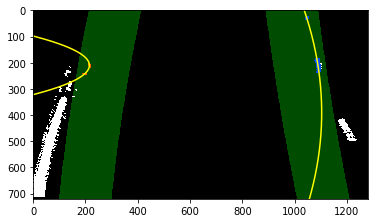

In [53]:
exampleImg2 = mpimg.imread('test_images/test6.jpg')
exampleImg2_bin = pipeline(exampleImg2, src, dst)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [54]:
def sliding_window(warped_bin):
    histogramx = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=0)
    histogramy = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=1)
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin)) * 255
    
    midpoint = np.int(len(histogramx)/2)
    leftx_base = np.argmax(histogramx[:midpoint])
    rightx_base = np.argmax(histogramx[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(warped_bin.shape[0]/nwindows)
    
    nonzero = warped_bin.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 70

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = warped_bin.shape[0] - (window+1)*window_height
        win_y_high = warped_bin.shape[0] - (window)*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [83]:
def draw_lane(original_img, binary_img, l_fit, r_fit, src, dst):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        print("in draw found l_fit/r_fit None: ", l_fit, r_fit)
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, src, dst)
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

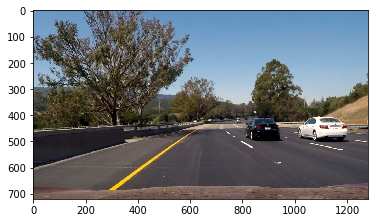

In [77]:
exampleImg_out1 = draw_lane(exampleImg2, exampleImg2_bin, left_fit, right_fit, dst, src)
plt.imshow(exampleImg_out1)

In [86]:
from moviepy.editor import VideoFileClip

def process_image(image):
    global left_fit
    global right_fit
    original_image = np.copy(image)
    image_bin = pipeline(image, src, dst)
#     return image_bin
    if left_fit is None or right_fit is None:
        print("left fit or right fit not found", left_fit, right_fit)
        left_fit, right_fit = sliding_window(image_bin)

    left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_prev_fit(image_bin, left_fit, right_fit)
    return draw_lane(original_image, image_bin, left_fit, right_fit, dst, src)

In [87]:
def warp_image(image):
    return warp(image, src, dst)

In [88]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(0,2)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

left fit or right fit not found None [  1.77242957e-04   8.23094202e-01   6.98427018e+02]
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 98%|█████████▊| 50/51 [00:01<00:00, 26.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3.25 s, sys: 197 ms, total: 3.44 s
Wall time: 2.87 s


In [85]:
left_fit = None
right_for = None